# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview
Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter


In [3]:
df = pd.read_csv('telco.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

accuracy - fraction of correct predictions

In [8]:
(y_val == churn_decision).mean()

0.8034066713981547

In [9]:
#accuracy is basically percentage of corrrect decisions
(y_val == churn_decision).sum()/(len(y_val))

0.8034066713981547

In [10]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [11]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


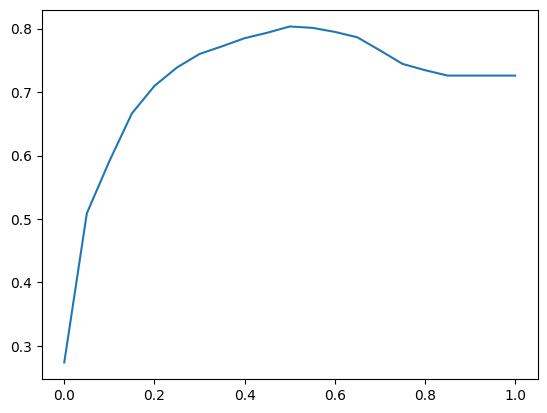

In [12]:
plt.plot(thresholds, scores)

In [13]:
from collections import Counter

Counter(y_pred >= 1.0)


Counter({False: 1409})

In [14]:
1 - y_val.mean()


0.7260468417317246

## 4.3 Confusion Table
Different types of errors and correct decisions
Arranging them in a table

In [15]:
actual_positive = (y_val ==1)
actual_negative = (y_val==0)

In [16]:
predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5)

In [17]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

fp = (actual_negative & predict_positive).sum()
fn = (actual_positive & predict_negative).sum()

In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

#false negative is much higher than false positive in our algo, where we will send the customers with promotion when they were not churning

![Alt text](image.png)

![Alt text](image-1.png)

## 4.4 Precision and Recall

In [20]:
accuracy = (tp+tn) / (tp+tn+fp+fn)
accuracy

0.8034066713981547

### Precision 
Fraction of positive predictions that are correct

![Alt text](image-2.png)

In [21]:
precision = (tp) / (tp+fp)
precision

0.6752411575562701

### Recall

Fraction of correctly identified positive examples

![Alt text](image-3.png)

In [22]:
recall = tp / (tp +fn)
recall

0.5440414507772021

![Alt text](image-4.png)

# 4.5 ROC Curves

### TPR and FRP

tpr - true positive rate
fpr - false positive rate


### FPR
- it is fractipon false postive among all positive examples
FPR = FP / FP + TN

TPR = TP / TP + FN

![Alt text](image-6.png)


In [23]:
tpr = tp / (tp + fn) # this is same as recall
tpr


0.5440414507772021

In [24]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [25]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val ==1)
    actual_negative = (y_val==0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()

    scores.append((t, tp, tn , fp , fn))

In [26]:
columns = ['threshold', 'tp','tn','fp','fn']
df_scores = pd.DataFrame(scores, columns  = columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,110,913,1
2,0.02,384,193,830,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [27]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] =  df_scores.fp / (df_scores.fp + df_scores.tn)

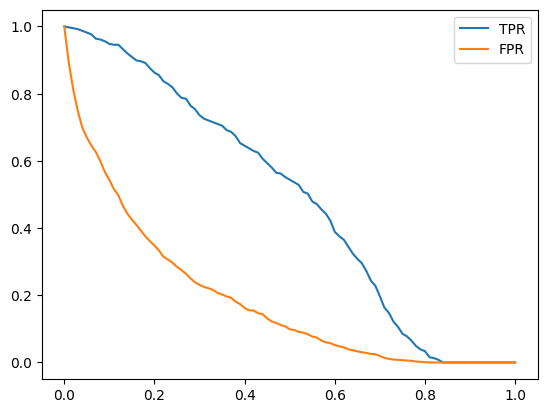

In [28]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

### Minimize FPR and Maximize TPR

## Random model

In [29]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [30]:
((y_rand>=0.5) == y_val).mean()

0.5017743080198722

In [31]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_positive = (y_val ==1)
        actual_negative = (y_val==0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()

        scores.append((t, tp, tn , fp , fn))

    columns = ['threshold', 'tp','tn','fp','fn']
    df_scores = pd.DataFrame(scores, columns  = columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] =  df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores
    

In [32]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

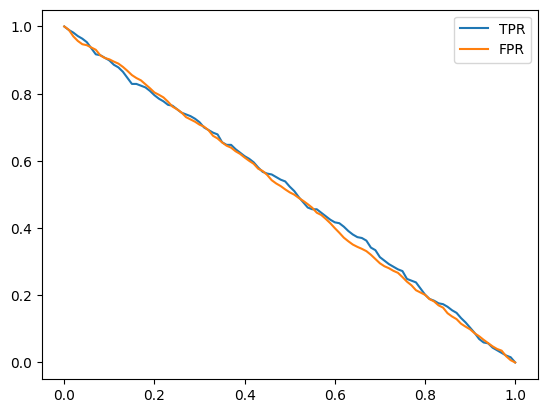

In [33]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend()

![Alt text](image-7.png)

## Ideal model/

In [34]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [35]:
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
y_ideal_pred = np.linspace(0,1,len(y_val))


In [37]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [38]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

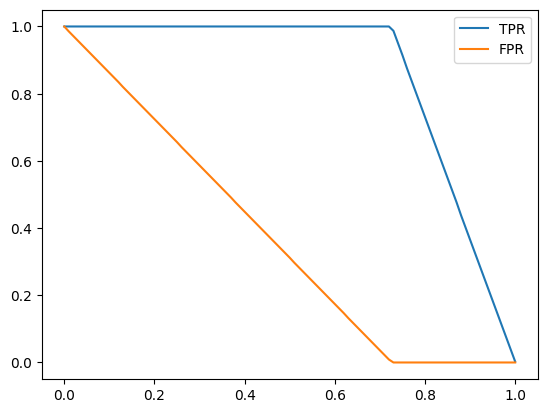

In [39]:
df_ideal[::10]

plt.plot(df_rand.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend()

## Putting everything together

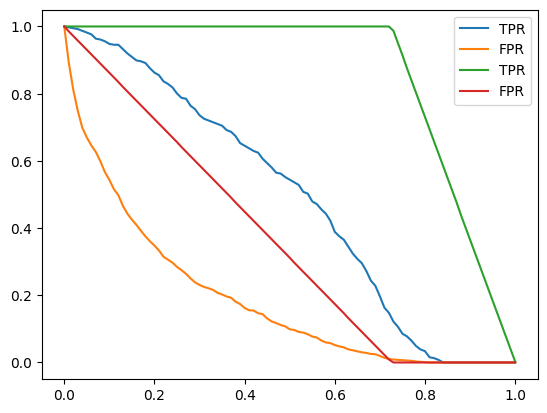

In [45]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')


# plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')

plt.legend()

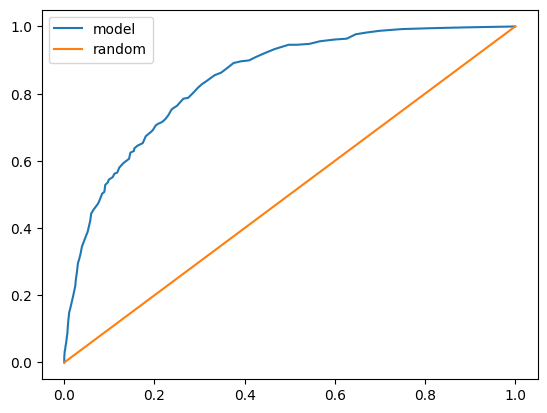

In [49]:
plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot([0,1],[0,1], label = 'random')

#plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.legend()

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

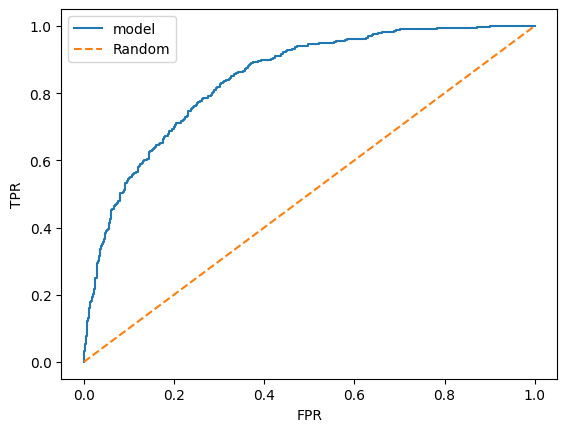

In [43]:
plt.plot(fpr, tpr, label = 'model')
plt.plot([0,1],[0,1],label = 'Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# 4.6 ROC AUC 

- Area under the ROC curve - useful metric
- Interpretation of AUC


AUC tells what is the probability that the randomly selected positive example that has a score higher than the rnadomly selected neagtive exaple 

In [50]:
from sklearn.metrics import auc

In [51]:
auc(fpr, tpr)

0.843850505725819

In [53]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [54]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.843850505725819

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.843850505725819

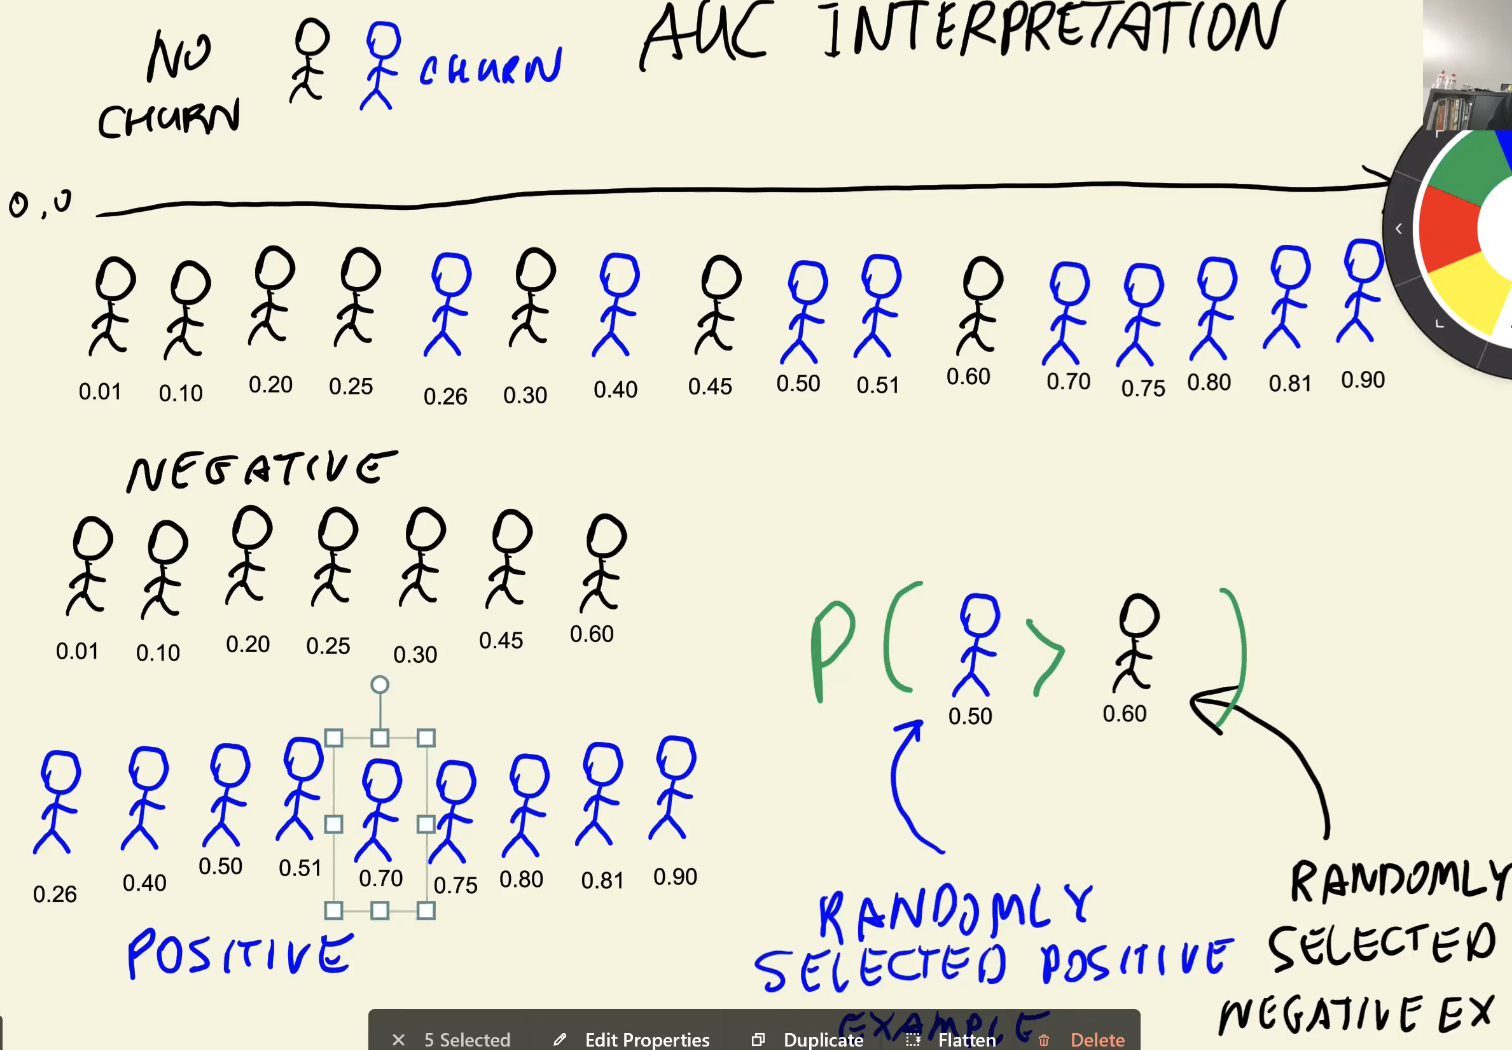

In [59]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [63]:
# randmoly select positive example
import random

n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg)-1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8485

In [68]:
n=50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84396

# 4.8 Cross validation

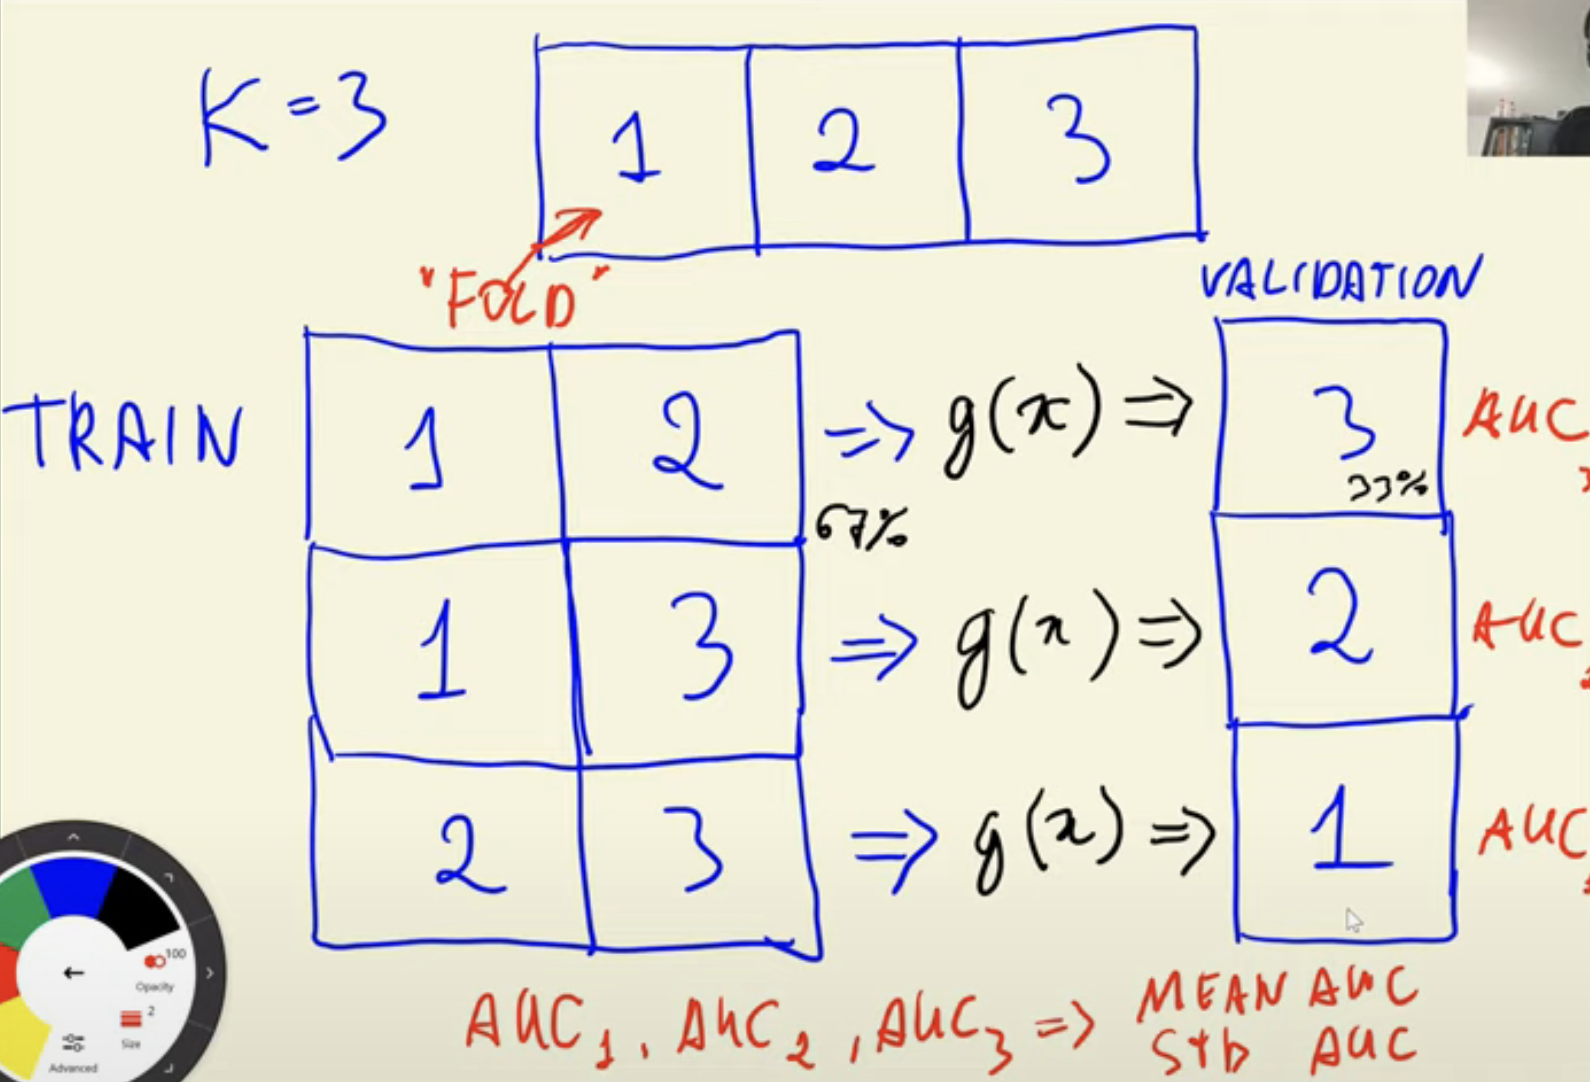

In [86]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold


In [92]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [93]:
dv, model = train(df_train, y_train, C=0.001)


In [94]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [95]:
y_pred = predict(df_val, dv, model)

In [96]:
from sklearn.model_selection import KFold

In [97]:
n_splits = 5

# C = regularization parameter for the model
# tqdm() is a function that prints progress bars
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.840 +- 0.008
C=0.5 0.841 +- 0.006
C=1 0.841 +- 0.008
C=5 0.841 +- 0.007
C=10 0.841 +- 0.008


In [98]:
scores

[0.8438154971701298,
 0.8436361905707853,
 0.8325667268713626,
 0.8319590554454179,
 0.8523226444102789]

In [99]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259